In [14]:
import jax.numpy as jnp
from jax import random
import jax
from tqdm import tqdm

def rrt(start, bounds, max_iter=1000, step_size=0.1, goal_bias=0.1):
    """
    Implements the RRT algorithm to explore a 2D space.

    Args:
        start (tuple): The starting point of the search.
        goal (tuple): The goal point of the search.
        bounds (tuple): The bounds of the search space.
        max_iter (int): The maximum number of iterations to run the algorithm.
        step_size (float): The step size to use when growing the tree.
        goal_bias (float): The probability of sampling the goal point.

    Returns:
        A list of points in the search space that were explored by the algorithm.
    """

    # Define the distance function
    @jax.jit
    def distance(p1, p2):
        return jnp.sqrt(jnp.sum((p1 - p2) ** 2))

    # Initialize the tree with the starting point
    tree = [start]
    vertices = []
    minval = jnp.array([bounds[0][0], bounds[1][0]])
    maxval = jnp.array([bounds[0][1], bounds[1][1]])

    # Loop until the maximum number of iterations is reached
    for i in tqdm(range(max_iter)):

        # Sample a point from the search space
        q = random.uniform(random.PRNGKey(i), shape=(2,), minval=minval, maxval=maxval)

        # Find the nearest point in the tree
        nearest = min(tree, key=lambda x: distance(x, q))

        # Grow the tree towards the new point
        new_point = nearest + step_size * (q - nearest) / distance(nearest, q)

        # Check if the new point is within the bounds of the search space
        # print(new_point, bounds)
        if bounds[0][0] < new_point[0] < bounds[0][1] and bounds[1][0] < new_point[1] < bounds[1][1]:

            # Add the new point to the tree
            tree.append(new_point)
            vertices.append((nearest, new_point))
            # print("Added point", new_point)
    return tree, vertices

In [15]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define the search space bounds
bounds = jnp.array([[-5, 5], [-5, 5]])

# Define the starting and goal points
start = jnp.array((0, 0))

max_iter=1000

# Run the RRT algorithm
tree, vertices = rrt(start, bounds, max_iter=max_iter, step_size=0.2, goal_bias=0)


100%|██████████| 1000/1000 [01:40<00:00,  9.91it/s]


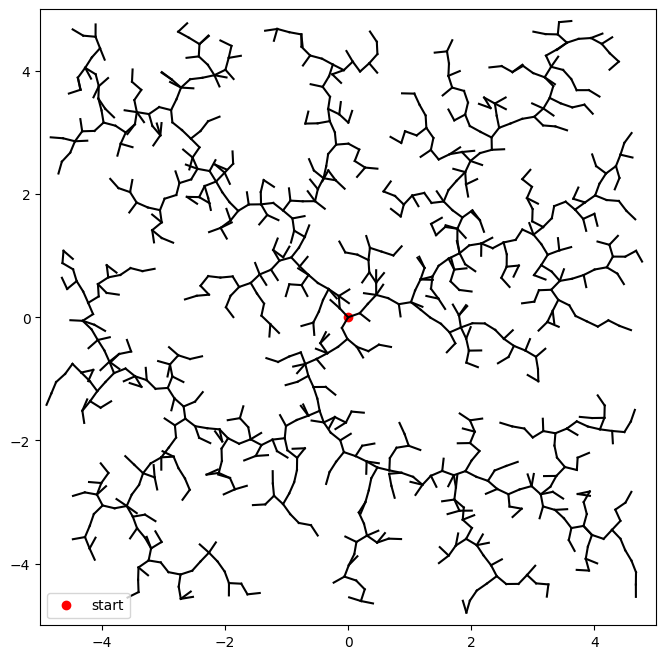

In [18]:
# Plot the results and animate it
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
ax.set_aspect("equal")
ax.plot(start[0], start[1], "ro", label="start")
for v in vertices:
    ax.plot([v[0][0], v[1][0]], [v[0][1], v[1][1]], "k-")
ax.legend()
plt.show()

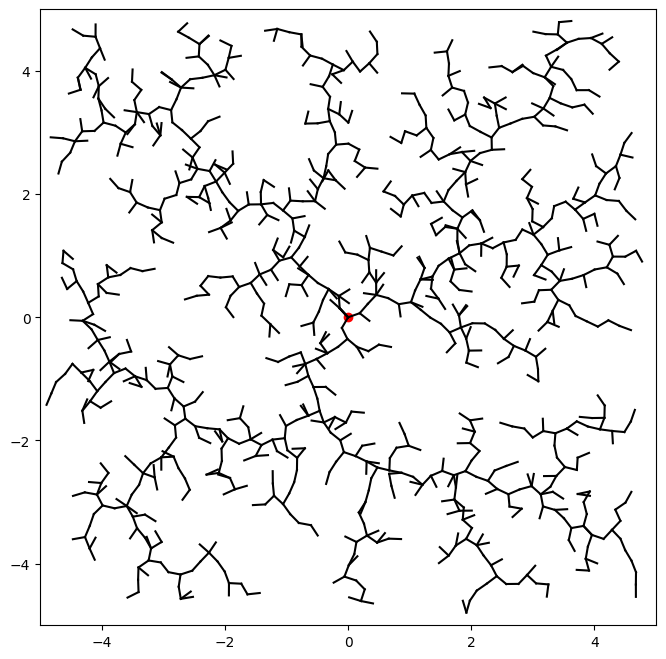

In [19]:
# animation
from matplotlib import animation
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, PillowWriter


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
ax.set_aspect("equal")
ax.plot(start[0], start[1], "ro", label="start")

def animate(i):
    v = vertices[i]
    plt.plot([v[0][0], v[1][0]], [v[0][1], v[1][1]], "k-")
    return (fig,)

# use ImageMagick
anim = animation.FuncAnimation(fig, animate, frames=len(tree) - 1, interval=100, blit=True)
anim.save("RRT.gif", writer=PillowWriter(fps=20))


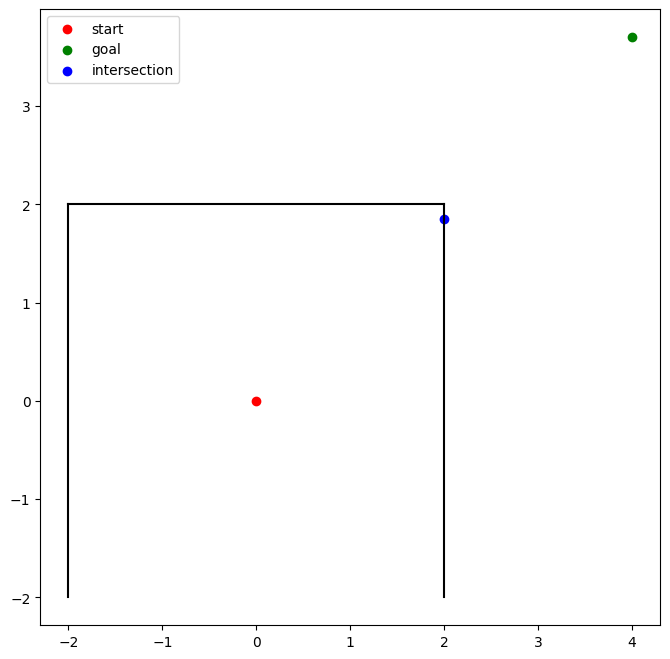

In [1]:
from typing import List, Tuple
import jax.numpy as jnp
from jax import random
import jax
from tqdm import tqdm
import matplotlib.pyplot as plt

def find_intersection_point(v1, v2):
    # Find the intersection point between two segments
    # v1 and v2 are two segments defined by two points each
    # v1 = (a1, b1), v2 = (a2, b2)
    # a1, b1, a2, b2 are all 2D vectors
    # Returns the intersection point if it exists, None otherwise
    # The intersection points must be within the bounds of the segments
    # Uses jax vmap to vectorize the computation
    # print(v1, v2)
    a1, b1 = v1
    x1, y1 = a1
    x2, y2 = b1

    a2, b2 = v2
    x3, y3 = a2
    x4, y4 = b2

    # print(x1, y1, x2, y2, x3, y3, x4, y4)

    # Compute the intersection point
    # https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#Given_two_points_on_each_line
    x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / (
        (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    )
    y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / (
        (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    )

    # Check if the intersection point is within the bounds of the segments
    # https://stackoverflow.com/questions/328107/how-can-you-determine-a-point-is-between-two-other-points-on-a-line-segment
    def is_between(a, b, c):
        crossproduct = (c[1] - a[1]) * (b[0] - a[0]) - (c[0] - a[0]) * (b[1] - a[1])
        if abs(crossproduct) != 0:
            return False

        dotproduct = (c[0] - a[0]) * (b[0] - a[0]) + (c[1] - a[1]) * (b[1] - a[1])
        if dotproduct < 0:
            return False

        squaredlengthba = (b[0] - a[0]) * (b[0] - a[0]) + (b[1] - a[1]) * (b[1] - a[1])
        if dotproduct > squaredlengthba:
            return False

        return True
    
    if is_between(a1, b1, (x, y)) and is_between(a2, b2, (x, y)):
        return jnp.array((x, y))
    else:
        return None
    

class Maze:
    walls: List[Tuple[float, float, float, float]]

    def __init__(self, walls: List[Tuple[float, float, float, float]], thickness=0.1):
        self.walls = walls
        self.thickness = thickness

    def __call__(self, p1, p2):
        for wall in self.walls:
            if self.is_collision(p1, p2, wall):
                return True
        return False
    
    def intersect_with_thickness(self, p1, p2):
        v = [p1, p2]
        for wall in self.walls:
            intersection = find_intersection_point(v, wall)
            if intersection is not None:
                # If there is an intersection, find the point on the segment that is `thickness` 
                # away from the intersection point
                # https://math.stackexchange.com/questions/175896/finding-a-point-along-a-line-a-certain-distance-away-from-another-point
                # x1, y1 = p1
                # x2, y2 = p2
                # x3, y3 = intersection
                # d = self.thickness
                # x4 = x3 + d * (y1 - y2) / jnp.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                # y4 = y3 + d * (x2 - x1) / jnp.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                # return jnp.array((x4, y4))
                return intersection
        return p2
    
    def plot(self, ax):
        for wall in self.walls:
            p1, p2 = wall
            x1, y1 = p1
            x2, y2 = p2
            ax.plot([x1, x2], [y1, y2], "k-")

maze = Maze([
    ([-2, -2], [-2, 2]),
    ([-2, 2], [2, 2]),
    ([2, 2], [2, -2]),
])

# Define the search space bounds
bounds = jnp.array([[-5, 5], [-5, 5]])

# Define the starting and goal points
start = jnp.array((0, 0))
goal = jnp.array((4, 3.7))

fig, ax = plt.subplots(figsize=(8, 8))
maze.plot(ax)
ax.scatter(start[0], start[1], c="r", label="start")
ax.scatter(goal[0], goal[1], c="g", label="goal")

# find intersection 
intersection = maze.intersect_with_thickness(start, goal)
if intersection is not None:
    ax.scatter(intersection[0], intersection[1], c="b", label="intersection")
ax.legend()

In [2]:
# Sample random points in the search space
rng = random.PRNGKey(0)
minval = jnp.array([bounds[0][0], bounds[1][0]])
maxval = jnp.array([bounds[0][1], bounds[1][1]])
points = random.uniform(rng, (10, 2), minval=minval, maxval=maxval)

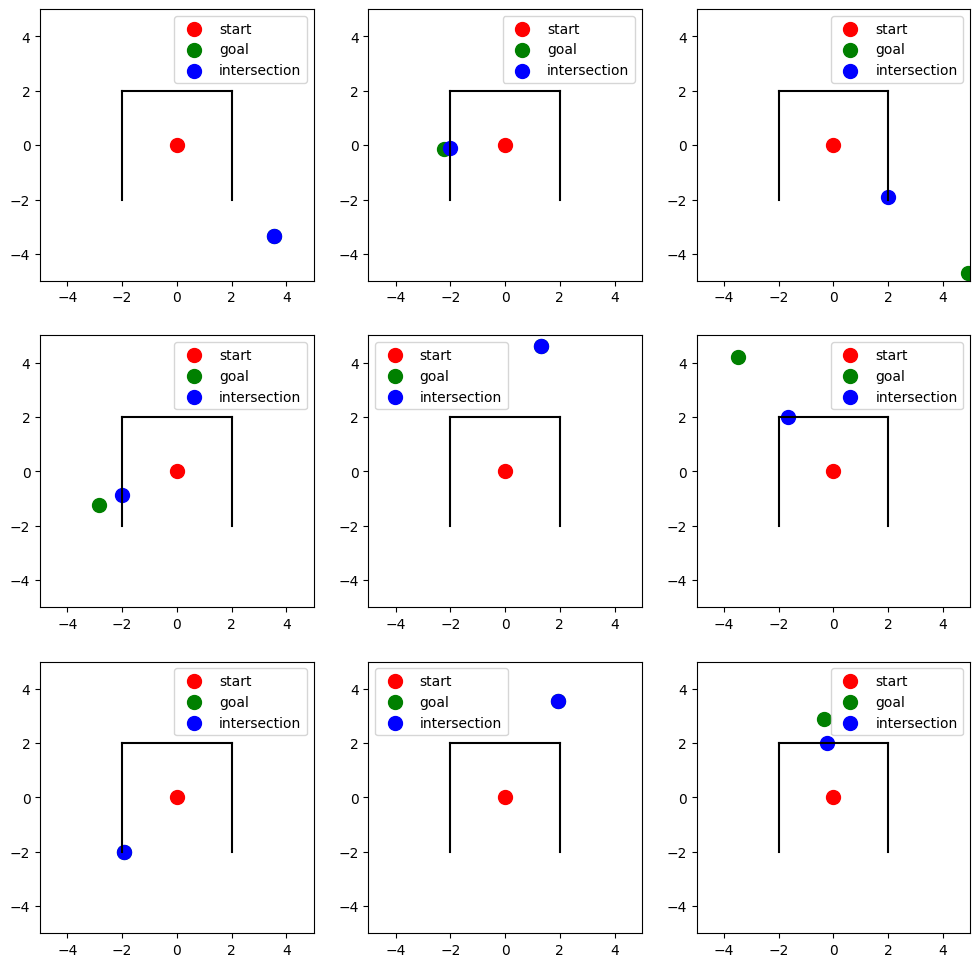

In [4]:
# 9 subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
index = 0
for i in range(3):
    for j in range(3):
        goal = points[index]
        index += 1
        intersection = maze.intersect_with_thickness(start, goal)
        ax = axs[i, j]
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        maze.plot(ax)
        ax.scatter(start[0], start[1], c="r", label="start", s=100)
        ax.scatter(goal[0], goal[1], c="g", label="goal", s=100)
        # cross for intersection
        if intersection is not None:
            ax.scatter(intersection[0], intersection[1], c="b", label="intersection", s=100)
        ax.legend()

In [5]:
# Check if the vector from start to each of the random points intersects with any of the walls
collisions = [
    maze.intersect_with_thickness(start, point) for point in points
]

In [6]:
collisions = jnp.array(collisions)

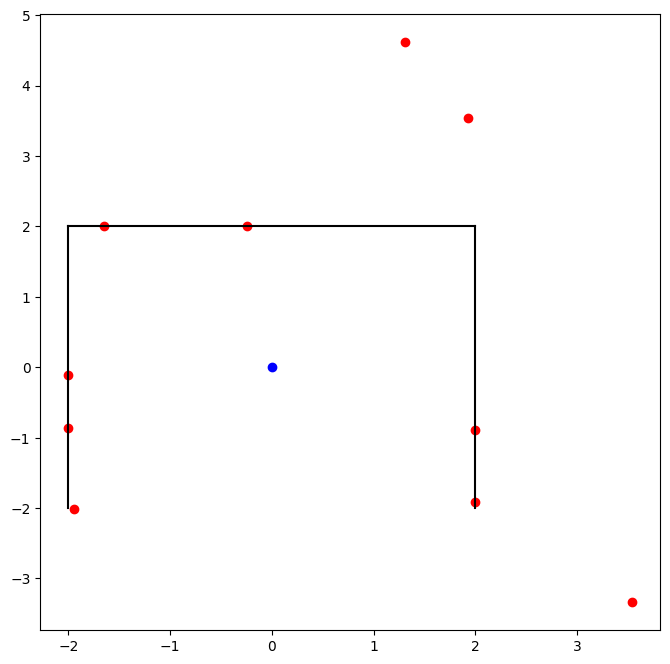

In [7]:
# Plot all points, colored by whether they intersect with a wall
fig, ax = plt.subplots(figsize=(8, 8))
maze.plot(ax)
ax.scatter(start[0], start[1], c="b", label="start")
ax.scatter(collisions[:, 0], collisions[:, 1], c="r", label="collisions")
